# Übung 12: Numerische Untersuchung des linearen Standardkörpers

---

## Der lineare Standardkörper

In dieser Programmierübung soll das Verhalten des linearen Standardkörpers zur Beschreibung von viskoelastischem Materialverhalten numerisch untersucht werden. Wie unten dargestellt besteht der lineare Standardkörper aus einem Maxwell-Körper welcher mit einem Hooke-Element parallel geschaltet wird.
<p style="padding: 5px 0 5px 0;">
<img src="standardkoerper.png" width="325" style="display: block; margin: 0 auto;" />
</p>
Die Differentialgleichung des linearen Standardkörpers wurde in einer vergangenen Übung durch Auflösen der Reihen- und Parallelschaltung hergeleitet.
<p style="padding: 15px 0 4px 0;">
$$\normalsize\begin{gather}
\sigma + \dfrac{\eta}{E} \, \dot{\sigma} = E_\infty \, \varepsilon + \dfrac{\eta}{E} \, \left[E_\infty + E\right] \, \dot{\varepsilon} \, .
\end{gather}$$
</p>
Das viskoelastische Materialverhalten wurde anschließend über analytische Lösungen mit entsprechenden Ansatzfunktionen und Anfangsbedingungen für einen komplexen Belastungsverlauf bestimmt. In dieser Übung soll das Materialverhalten alternativ über einen numerischen Lösungsansatz gelöst werden.

---
## Numerische Berechnungsformeln

Die numerischen Berechnungsformeln zur Lösung des linearen Standardkörper wurden bereits in einer vergangenen Vorlesung hergeleitet. Die Update-Formel für die Spannung $\sigma$ und die Evolutionsgleichung der viskosen Dehnung $\dot{\varepsilon}_\mathrm{v}$ ergeben sich für eine als bekannt vorausgesetzte Dehnung $\varepsilon$ zu
<p style="padding: 2px 0 0px 0;">
$$\normalsize\begin{gather}
\sigma\!\left(\varepsilon, \varepsilon_\mathrm{v}\right) = E \, \left[\varepsilon - \varepsilon_\mathrm{v}\right] + E_\infty \, \varepsilon \, , \\[1ex]
\dot{\varepsilon}_\mathrm{v} = \dfrac{E}{\eta} \, \left[\varepsilon - \varepsilon_\mathrm{v}\right] \, .
\end{gather}$$
</p>

### Numerische Integration der Evolutionsgleichung

Um ein Update für die viskose Dehnung $\varepsilon_\mathrm{v}$ zu erhalten, wird eine Zeitdiskretisierung eingeführt und die obige Evolutionsgleichung $\dot{\varepsilon}_\mathrm{v}$ über den impliziten Euler rückwärts numerisch integriert. Ausgehend von der vorgeschriebenen Dehnung $\varepsilon_{n+1}$ und der bekannten viskosen Dehnung $\varepsilon_{\mathrm{v}\,n}$ aus dem letzten Zeitschritt ergibt sich
<p style="padding: 2px 0 10px 0;">
$$\normalsize\begin{gather}
\dfrac{\varepsilon_{\mathrm{v}\,n+1} - \varepsilon_{\mathrm{v}\,n}}{\Delta t} = \dot{\varepsilon}_{\mathrm{v}} \, \vert_{n+1}  = \dfrac{E}{\eta} \, \left[\varepsilon_{n+1} - \varepsilon_{\mathrm{v}\,n+1} \right] \, .
\end{gather}$$
</p>

---
## Update der Spannung und viskosen Dehnung

Unter Berücksichtigung der Zeitdiskretisierung lässt sich die Spannung $\sigma$ im aktuellen Zeitschritt darstellen als
<p style="padding: 5px 0 5px 0;">
$$\normalsize\begin{gather}
\sigma_{n+1}\!\left(\varepsilon_{n+1}, \varepsilon_{\mathrm{v}\,n}\right) = E \, \left[\varepsilon_{n+1} - \varepsilon_{\mathrm{v}\,n+1}\right] + E_\infty \, \varepsilon_{n+1} \, .
\end{gather}$$
</p>

Durch Umformung der zeitintegrierten Evolutionsgleichung ergibt sich die viskose Dehnung $\varepsilon_\mathrm{v}$ im aktuellen Zeitschritt schließlich zu
<p style="padding: 5px 0 0px 0;">
$$\normalsize\begin{gather}
\varepsilon_{v\,n+1} = \left[1 + \dfrac{\Delta t}{\tau}\right]^{-1} \left[\varepsilon_{\mathrm{v}\,n} + \dfrac{\Delta t}{\tau} \, \varepsilon_{n+1}\right] \, , \quad \tau = \dfrac{\eta}{E} \, .
\end{gather}$$
</p>

---
# Umsetzung in Python

Für die schrittweise Berechnung der numerischen Lösung des linearen Standardkörpers bietet sich eine Implementierung in Python an.

## Import aller benötigten Bibliotheken

Zunächst werden die für die numerische Umsetzung benötigten Python-Bibliotheken importiert.

In [1]:
# Erforderliche Bibliotheken importieren
import numpy as np                # Für numerische Berechnungen
from scipy.optimize import fsolve # Zur Lösung von Gleichungssystemen
import matplotlib.pyplot as plt   # Für die Erstellung von Plots

Des Weiteren werden einige Standard-Einstellungen für die Darstellung der nachfolgenden Diagramme mit matplotlib festgelegt, wie beispielsweise die Linienstärke und Schriftgröße. Eine Übersicht über die verfügbaren Einstellungen finden Sie [hier](https://matplotlib.org/stable/tutorials/introductory/customizing.html).

In [2]:
# Darstellung der Plots anpassen
plt.rcParams['figure.figsize'] = [15,6] # Größe der Plots (Breite, Höhe) vorgeben
plt.rcParams['lines.linewidth'] = 2     # Linienstärke der Kurven anpassen
plt.rcParams['axes.grid'] = True        # Gitternetzlinien aktivieren
plt.rcParams['font.size'] = 14          # Schriftgröße auf 14 Punkt einstellen

---
# Bestimmung der Spannung für eine vorgegebene Dehnung

Es soll zunächst eine Funktion implementiert werden, welche für eine vorgegebene Dehnung $\varepsilon_{n+1}$ die Updates der Spannung $\sigma_{n+1}$ und der viskosen Dehnung $\varepsilon_{\mathrm{v}\,n+1}$ berechnet. Die Funktion benötigt dazu die Materialparameter $E_\infty$, $E$, $\eta$ sowie die viskose Dehnung $\varepsilon_{\mathrm{v}\,n}$ aus dem letzten Zeitschritt und die Zeitschrittweite $\Delta t$.

---
**Aufgabe**

Vervollständigen Sie die Funktion `stress` zur Bestimmung der Spannung $\sigma_{n+1}$ und der viskosen Dehnung $\varepsilon_{\mathrm{v}\,n+1}$ im aktuellen Zeitschritt.

In [3]:
# Achtung: Die Benennung der Funktion und die Reihenfolge der Variablen sollte beibehalten werden!
def stress(eps, epsvn, dt, Einf, E, eta):
    """
    Berechnet die Spannung (sig) und die viskose Dehnung (epsv) des linearen Standardkörpers.
    """
    
    # Berechnung der Relaxationszeit tau
    tau = eta / E

    # Update der viskosen Dehnung (implizites Euler rückwärts Verfahren)
    epsv = (1 + dt / tau) ** (-1) * (epsvn + dt / tau * eps)

    # Update der Spannung aus den Dehnungen
    sig = Einf * eps + E * (eps - epsv)

    return sig, epsv

**Überprüfung der Implementierung**

Die folgende Zelle testet Ihre Implementierung der Funktion `stress` gegenüber einer Referenzlösung. Sollten Abweichungen auftreten, überprüfen und korrigieren Sie Ihre Funktion. Führen Sie anschließend diese Zelle erneut aus, um den Test zu wiederholen.

In [4]:
# Testfunktion aus Musterlösung importieren
from musterloesungen import test_stress

# Implementierung der Spannungsfunktion überprüfen
test_stress(stress)

Die Funktion ist korrekt.


---
# Beispiel: Relaxationsversuch

Im Folgenden soll die Funktion `stress` verwendet werden, um die Spannungsantwort für einen Relaxationsversuch zu berechnen. Als Lastpfad soll ein sprunghaft ansteigender und anschließend konstant gehaltener Dehnungsverlauf $\varepsilon\!\left(t\right)$, wie unten abgebildet, vorgegeben werden.

<p style="padding: 15px 0 15px 0;">
<img src="prescribed_strains.png" width="900" style="display: block; margin: 0 auto;" />
</p>

---
**Aufgabe**

Vervollständigen Sie den Programmcode in der folgenden Zelle, um den oben dargestellten Dehnungsverlauf $\varepsilon_{n+1}\!\left(t\right)$ zu erzeugen.

**Hinweis**:
Die NumPy-Funktionen [`np.linspace`](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html), [`np.full`](https://numpy.org/doc/stable/reference/generated/numpy.full.html) und [`np.concatenate`](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html) werden verwendet.

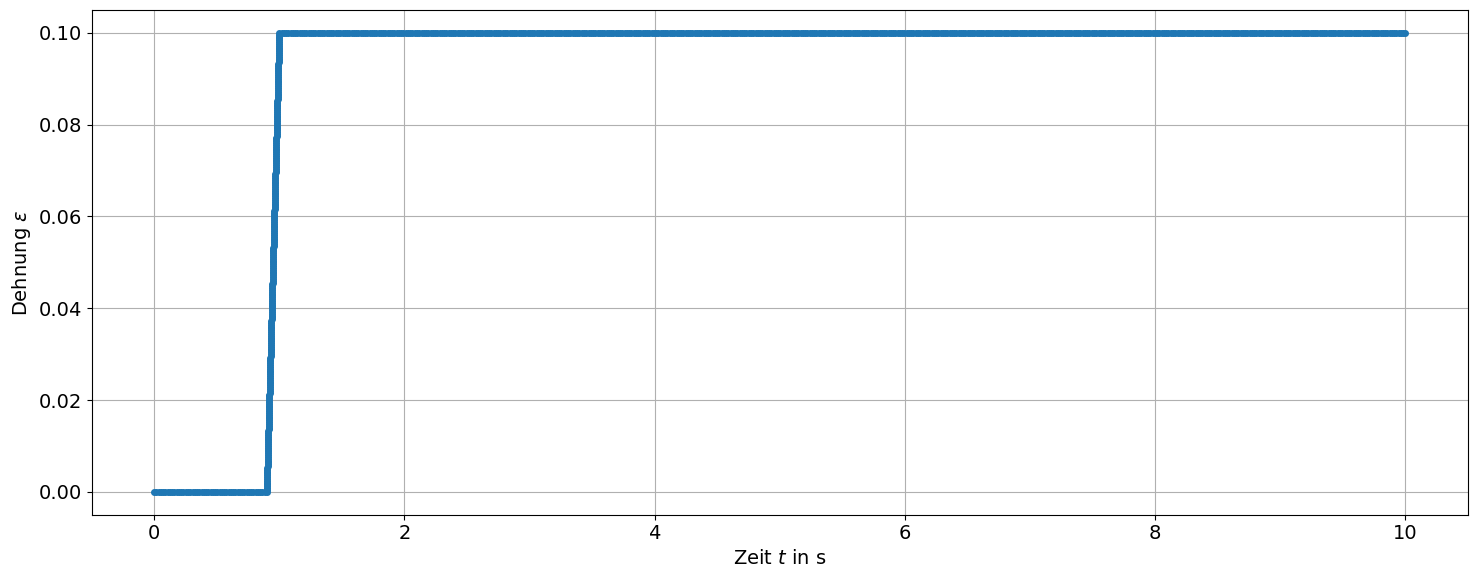

In [5]:
def generate_load(start_time, end_time, start_load, end_load, num_points=10, endpoint=True):
    """
    Generiert Zeitpunkte, Zeitinkremente und Dehnungswerte für einen Belastungsabschnitt.
    """

    # Zeitpunkte des Belastungsabschnitts erzeugen (lineare Interpolation)
    time_points = np.linspace(start_time, end_time, num_points, endpoint=endpoint) 

    # Dehnungswerte des Belastungsabschnitts erzeugen (lineare Interpolation)
    load_values = np.linspace(start_load, end_load, num_points, endpoint=endpoint)

    # Zeitinkremente des Belastungsabschnitts erzeugen (konstant)
    time_increments = np.full(num_points, (end_time - start_time) / num_points)

    # Rückgabe der Arrays mit Zeitpunkten, Zeitinkrementen und Dehnungswerten
    return time_points, time_increments, load_values 

# Skalierungsfaktor für die Anzahl der Datenpunkte pro Belastungsabschnitt
fct = 50

# Definition der Belastungsabschnitte
t_1, dt_1, eps_1 = generate_load(0.0, 0.9,  0.0, 0.0, 1*fct,  False)
t_2, dt_2, eps_2 = generate_load(0.9, 1.0,  0.0, 0.1, 5*fct,  False)
t_3, dt_3, eps_3 = generate_load(1.0, 10.0, 0.1, 0.1, 10*fct, True)

# Zusammenfügen der Arrays für die gesamte Belastung
t = np.concatenate([t_1, t_2, t_3])
dt = np.concatenate([dt_1, dt_2, dt_3])
eps = np.concatenate([eps_1, eps_2, eps_3])

# Plot: Zeitlicher Verlauf der Dehnung
plt.plot(t, eps, '-', marker='o', markersize=4)
plt.xlabel(r"Zeit $t$ in s")
plt.ylabel(r"Dehnung $\varepsilon$")
plt.tight_layout()

---
**Aufgabe**

Vervollständigen Sie den folgenden Programmcode, um die Materialantwort für den definierten Dehnungsverlauf $\varepsilon\!\left(t\right)$ im Relaxationsversuch zu berechnen.

**Hinweise**:
- Nehmen Sie für das initiale Zeitinkrement zum Zeitpunkt $t=0$ eine viskose Dehnung von $\varepsilon_{\mathrm{v}\,n} = 0$ an
- Verwenden Sie folgende Materialparameter: $E = 200$ MPa, $\,\eta = 100$ MPa s, $\,E_\infty = 200$ MPa

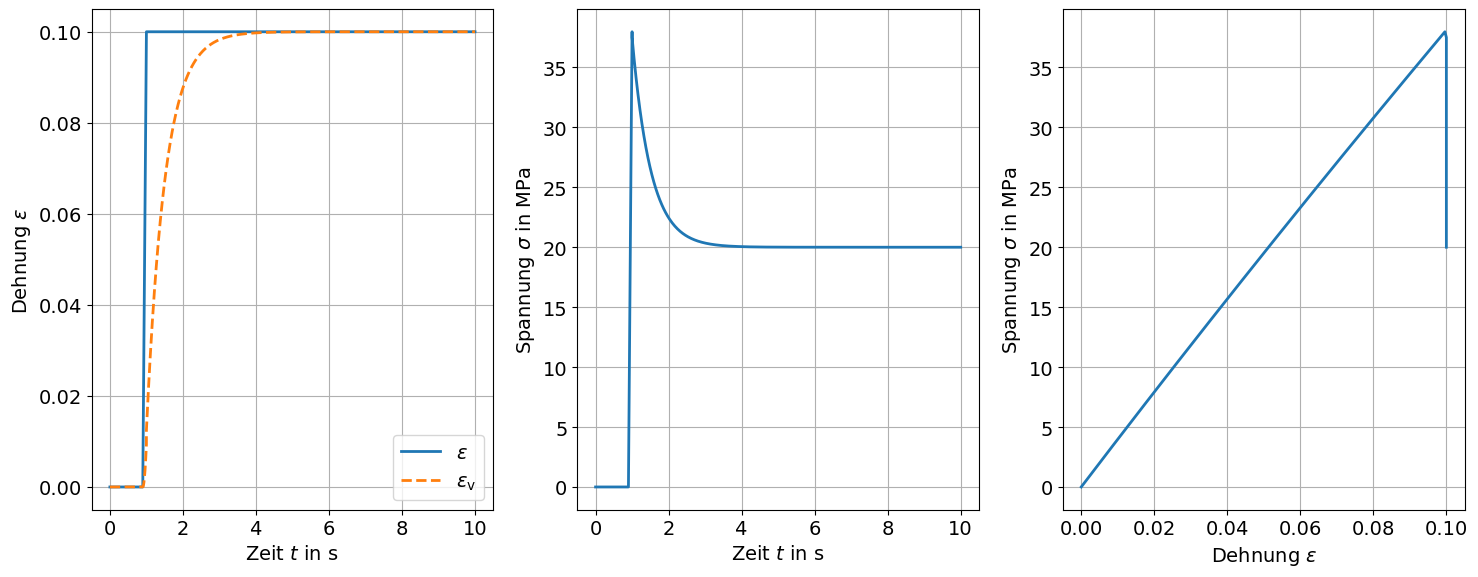

In [6]:
# Materialparameter des linearen Standardkörpers
E = 200.0 # MPa
eta = 100.0 # MPa s
Einf = 200.0 # MPa

# Initialisierung der Arrays für Spannung und viskose Dehnung
sig = np.zeros_like(eps)
epsv = np.zeros_like(eps) # (zu Beginn ist epsv = 0)

# Berechnung der Spannung und viskosen Dehnung für jeden Zeitschritt
for i in range(1, len(eps)):
    # Berechnung der aktuellen Spannung und viskosen Dehnung
    # unter Verwendung der Werte aus dem vorherigen Zeitschritt (i-1)
    sig[i], epsv[i] = stress(eps[i], epsv[i-1], dt[i], Einf, E, eta)

# Plot 1: Zeitlicher Verlauf der Dehnung
plt.subplot(131)
plt.plot(t, eps, '-', label=r'$\varepsilon$')
plt.plot(t, epsv, '--', label=r'$\varepsilon_\mathrm{v}$')
plt.xlabel(r'Zeit $t$ in $\mathrm{s}$ ')
plt.ylabel(r'Dehnung $\varepsilon$')
plt.legend()
plt.tight_layout()

# Plot 2: Zeitlicher Verlauf der Spannung
plt.subplot(132)
plt.plot(t, sig, '-')
plt.xlabel(r'Zeit $t$ in $\mathrm{s}$')
plt.ylabel(r'Spannung $\sigma$ in $\mathrm{MPa}$')
plt.tight_layout()

# Plot 3: Spannungs-Dehnungs-Diagramm
plt.subplot(133)
plt.plot(eps, sig, '-')
plt.xlabel(r'Dehnung $\varepsilon$')
plt.ylabel(r'Spannung $\sigma$ in $\mathrm{MPa}$')
plt.tight_layout()

---
# Numerische Lösung des Gleichungssystems

## Residuen-Format

Anstatt die zeitdiskretisierte Evolutionsgleichung manuell umzuformen und die explizite Formel zu lösen, kann die Evolutionsgleichung und die konstitutive Spannungsgleichung numerisch im Residuen-Format gelöst werden. Dazu werden die Gleichungen als Residuenvektor formuliert, bestehend aus
<p style="padding: 10px 0 25px 0;">
$$\normalsize
\mathbf{r} = \begin{bmatrix}
\sigma_{n+1} - E \left[\varepsilon_{n+1} - \varepsilon_{\mathrm{v}\,n+1}\right] - E_\infty \, \varepsilon_{n+1} \\
\dfrac{\varepsilon_{\mathrm{v}\,n+1} - \varepsilon_{\mathrm{v}\,n}}{\Delta t} - \dfrac{E}{\eta} \, \left[\varepsilon_{n+1} - \varepsilon_{\mathrm{v}\,n+1}\right]
\end{bmatrix} = \mathbf 0
\, .$$
</p>
Das Residuen-Format eignet sich nicht nur zur Lösung linearer Gleichungssysteme, sondern ist insbesondere bei komplexeren Modellen mit nichtlinearen Gleichungen von Vorteil (Übung 13). In dieser Übung werden wir das Residuen-Format zur Berechnung der Materialantwort bei einem Kriechversuch nutzen.

---
**Aufgabe**

Implementieren Sie die Funktion `res`, welche den Residuenvektors $\mathbf{r}$ basierend auf den oben aufgestellten Gleichungen berechnet.

In [7]:
def res(eps, sig, epsv, epsvn, dt, Einf, E, eta):
    """
    Berechnet das Residuum des linearen Standardkörpers für gegebene Werte.
    """
    
    # Residuum der Spannungs-Dehnungs-Beziehung (konstitutive Gleichung)
    r1 = sig - E * (eps - epsv) - Einf * eps  

    # Residuum der Fließregel (Evolutionsgleichung für die viskose Dehnung)
    r2 = (epsv - epsvn) / dt - E / eta * (eps - epsv)  

    return np.array([r1, r2])

**Überprüfung der Implementierung**

Die folgende Zelle testet Ihre Implementierung der Funktion `res` gegenüber einer Referenzlösung. Sollten Abweichungen auftreten, überprüfen und korrigieren Sie Ihre Funktion. Führen Sie anschließend diese Zelle erneut aus, um den Test zu wiederholen.

In [8]:
# Testfunktion aus Musterlösung importieren
from musterloesungen import test_residuum

# Implementierung der Residuenfunktion überprüfen
test_residuum(res)

Die Funktion ist korrekt.


---
# Beispiel: Relaxationsversuch über das Residuen-Format

In diesem Abschnitt soll die Spannungsantwort $\sigma\!\left(t\right)$ und der zeitliche Verlauf der viskosen Dehnung $\varepsilon_\mathrm{v}\!\left(t\right)$ für den zuvor definierten Dehnungsverlauf $\varepsilon\!\left(t\right)$ im Relaxationsversuch erneut berechnet werden. Im Gegensatz zur vorherigen Berechnung soll diesmal der Residuenvektor $\boldsymbol r = \boldsymbol 0$ gelöst werden.

Für diese Aufgabe soll die SciPy-Funktion `fsolve` verwendet werden, welche mindestens die folgenden Argumente benötigt:
- Eine Funktion (hier `res_function`), welche ein Array `x` mit den Werten der Unbekannten ($\sigma_{n+1}$ und $\varepsilon_{\mathrm{v}\,n+1}$) als einziges Argument erhält
- Ein Array `x0` mit Startwerten für die Unbekannten. Verwenden Sie zunächst die Startwerte $\boldsymbol x_0 = \boldsymbol 0$.

---
**Aufgabe**

Implementieren Sie die Funktion `stress_res`, welche die Materialantwort für den Relaxationsversuch durch Lösen der Residuen-Gleichung berechnet.

**Hinweis**:
Die Python-Funktion [`lambda`](https://www.w3schools.com/python/python_lambda.asp), die SciPy-Funktion [`fsolve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html) und die NumPy-Funktion [`np.allclose`](https://numpy.org/doc/stable/reference/generated/numpy.allclose.html) werden verwendet.

In [9]:
def stress_res(eps, epsvn, dt, Einf, E, eta, x0 = np.array([0.0, 0.0])):
    """
    Berechnet Spannung und viskose Dehnung durch Lösen der Residuen-Gleichung.
    """

    # Definition der Residuenfunktion als Lambda-Funktion
    # x[0] repräsentiert die Spannung (sig)
    # x[1] repräsentiert die viskose Dehnung (epsv)
    #                        res(eps, sig,  epsv, epsvn, dt, Einf, E, eta):
    res_function = lambda x: res(eps, x[0], x[1], epsvn, dt, Einf, E, eta)

    # Numerische Lösung der Residuen-Gleichung mit fsolve
    # x0 sind die Startwerte für die erste Iteration
    x = fsolve(res_function, x0)

    # Überprüfung, ob die gefundene Lösung das Residuum ausreichend minimiert
    assert np.allclose(res_function(x), np.zeros_like(x)), "Residuum nicht nahe Null!"

    # Rückgabe der berechneten Spannung (x[0]) und viskosen Dehnung (x[1])
    return x[0], x[1]

**Überprüfung der Implementierung**

Die folgende Zelle testet Ihre Implementierung der Funktion `stress_res` gegenüber einer Referenzlösung. Sollten Abweichungen auftreten, überprüfen und korrigieren Sie Ihre Funktion. Führen Sie anschließend diese Zelle erneut aus, um den Test zu wiederholen.

In [10]:
# Testfunktion aus Musterlösung importieren
from musterloesungen import test_stress_res

# Implementierung der kombinierten Spannungs- und Residuenfunktion überprüfen
test_stress_res(stress_res)

Die Funktion ist korrekt.


---
Im Folgenden sollen die beiden implementierten Lösungsmethoden (direkte Methode via `stress`, Residuen-Format via `stress_res`) für die Berechnung der Spannungsantwort im Relaxationsversuch verglichen werden. Bei korrekter Implementierung sollten beide Methoden dieselben Ergebnisse liefern.

---
**Aufgabe**

Vervollständigen Sie den folgenden Programmcode, um die Spannungsantwort des Relaxationsversuchs sowohl mit der direkten Methode (`stress`) als auch mit der Methode basierend auf dem Residuen-Format (`stress_res`) zu berechnen und die Ergebnisse zu vergleichen.

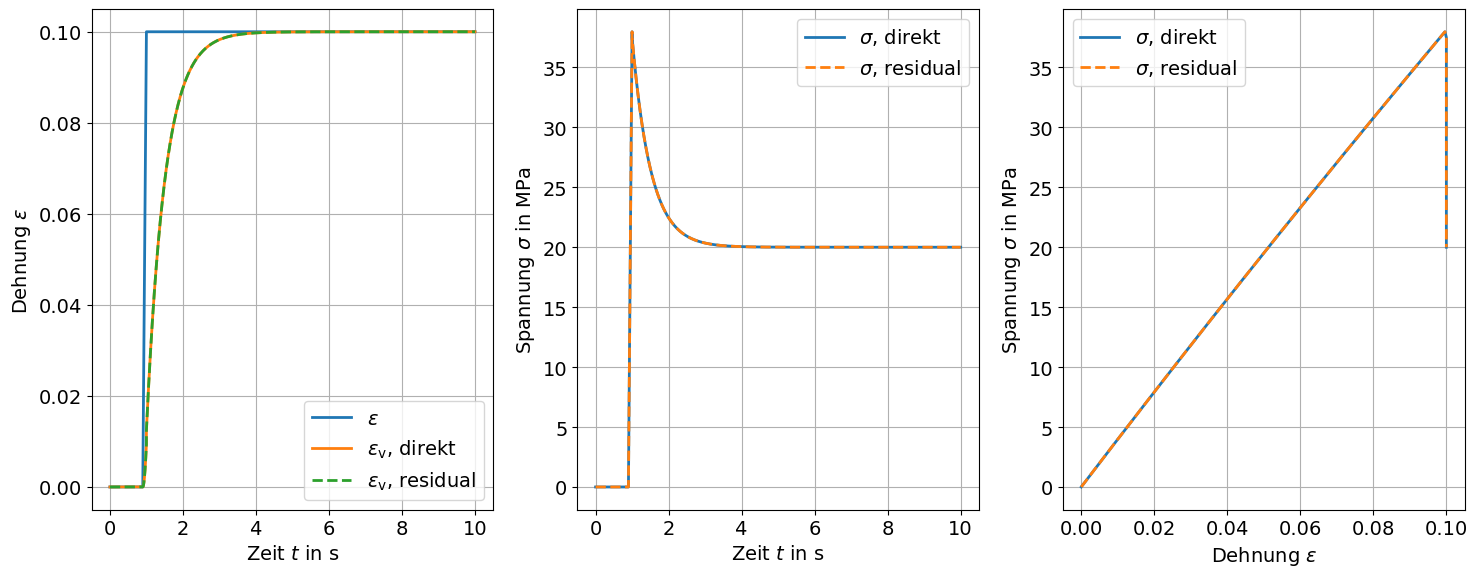

In [11]:
# Materialparameter des linearen Standardkörpers
E = 200.0 # MPa
eta = 100.0 # MPa s
Einf = 200.0 # MPa

# Initialisierung der Arrays für Spannung und viskose Dehnung (zwei Lösungsmethoden)
sig = np.zeros_like(eps)
epsv = np.zeros_like(eps) # (zu Beginn ist epsv = 0)
sig_res = np.zeros_like(eps)
epsv_res = np.zeros_like(eps) # (zu Beginn ist epsv_res = 0)

# Berechnung der Spannung und viskosen Dehnung für jeden Zeitschritt
for i in range(1, len(eps)):
    # Direkte Berechnung
    sig[i], epsv[i] = stress(eps[i], epsv[i-1], dt[i], Einf, E, eta)
    # Residuelle Berechnung
    sig_res[i], epsv_res[i] = stress_res(eps[i], epsv_res[i-1], dt[i], Einf, E, eta)
    
# Plot 1: Zeitlicher Verlauf der Dehnung
plt.subplot(131)
plt.plot(t, eps, '-', label=r'$\varepsilon$')
plt.plot(t, epsv, '-', label=r'$\varepsilon_\mathrm{v}$, direkt')
plt.plot(t, epsv_res, '--', label=r'$\varepsilon_\mathrm{v}$, residual')
plt.xlabel(r'Zeit $t$ in $\mathrm{s}$')
plt.ylabel(r'Dehnung $\varepsilon$')
plt.legend()
plt.tight_layout()

# Plot 2: Zeitlicher Verlauf der Spannung
plt.subplot(132)
plt.plot(t, sig, '-', label=r'$\sigma$, direkt')
plt.plot(t, sig_res, '--', label=r'$\sigma$, residual')
plt.xlabel(r'Zeit $t$ in $\mathrm{s}$ ')
plt.ylabel(r'Spannung $\sigma$ in $\mathrm{MPa}$')
plt.legend()
plt.tight_layout()

# Plot 3: Spannungs-Dehnungs-Diagramm
plt.subplot(133)
plt.plot(eps, sig, '-', label=r'$\sigma$, direkt')
plt.plot(eps, sig_res, '--', label=r'$\sigma$, residual')
plt.xlabel(r'Dehnung $\varepsilon$')
plt.ylabel(r'Spannung $\sigma$ in $\mathrm{MPa}$')
plt.legend()
plt.tight_layout()

----
# Beispiel: Kriechversuch über das Residuen-Format

Im vorherigen Relaxationsversuch wurde die Dehnung $\varepsilon\!\left(t\right)$ vorgegeben und die Materialantwort in Form der Spannung $\sigma\!\left(t\right)$ berechnet. Im Folgenden wollen wir das inverse Problem betrachten, indem wir die Spannung $\sigma\!\left(t\right)$ vorschreiben und die Materialantwort in Form der Dehnung $\varepsilon\!\left(t\right)$ berechnen.

Auch wenn die Gleichungen linear sind und somit eine direkte Umformulierung in Bezug auf die Spannung möglich wäre (wie in einer vorherigen Übung gezeigt), nutzen wir stattdessen das Residuen-Format. Dieses bietet den Vorteil, dass es sich leicht für andere Unbekannte anpassen lässt.

---
**Aufgabe**

Implementieren Sie die Funktion `strain_res`, welche die Dehnung $\varepsilon_{n+1}$ und die viskose Dehnung $\varepsilon_{\mathrm{v}\,n+1}$ durch Lösen der Residuen-Gleichung ermittelt.

**Hinweis**:
Die Python-Funktion [`lambda`](https://www.w3schools.com/python/python_lambda.asp), die SciPy-Funktion [`fsolve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html) und die NumPy-Funktion [`np.allclose`](https://numpy.org/doc/stable/reference/generated/numpy.allclose.html) werden verwendet.


In [12]:
def strain_res(sig, epsvn, dt, Einf, E, eta, x0=np.array([0., 0.])):
    """
    Berechnet Gesamtdehnung und viskose Dehnung durch Lösen der Residuen-Gleichung.
    """
    
    # Definition der Residuenfunktion als Lambda-Funktion
    # x[0] repräsentiert die Gesamtdehnung (eps)
    # x[1] repräsentiert die viskose Dehnung (epsv)
    #                        res(eps,  sig, epsv, epsvn, dt, Einf, E, eta):
    res_function = lambda x: res(x[0], sig, x[1], epsvn, dt, Einf, E, eta)
    
    # Numerische Lösung der Residuen-Gleichung mit fsolve
    # x0 sind die Startwerte für die Iteration
    x = fsolve(res_function, x0)
    
    # Überprüfung, ob die gefundene Lösung das Residuum ausreichend minimiert
    assert np.allclose(res_function(x), np.zeros_like(x))
    
    # Rückgabe der berechneten Gesamtdehnung (x[0]) und viskosen Dehnung (x[1])
    return x[0], x[1]

**Überprüfung der Implementierung**

Die folgende Zelle testet Ihre Implementierung der Funktion `strain_res` gegenüber einer Referenzlösung. Sollten Abweichungen auftreten,<br>überprüfen und korrigieren Sie Ihre Funktion. Führen Sie anschließend diese Zelle erneut aus, um den Test zu wiederholen.

In [13]:
# Testfunktion aus Musterlösung importieren
from musterloesungen import test_strain_res

# Implementierung der Dehnungs- und Residuenfunktion überprüfen
test_strain_res(strain_res)

Die Funktion ist korrekt.


---
Es soll nun die Materialantwort für den Kriechversuch mit einem sprunghaft ansteigenden und anschließend konstant gehaltenen Spannungsverlauf $\sigma\!\left(t\right)$ berechnet werden. Dabei sollen sowohl der Dehnungsverlauf $\varepsilon\!\left(t\right)$ als auch der Verlauf der viskosen Dehnung $\varepsilon_\mathrm{v}\!\left(t\right)$ bestimmt werden.

---
**Aufgabe**

Vervollständigen Sie den folgenden Programmcode, um die Materialantwort für den Kriechversuch zu berechnen.

**Hinweis**:
Orientieren Sie sich an der Implementierung des Relaxationsversuchs (Residuen-Format) und nutzen Sie die Funktion `strain_res`.

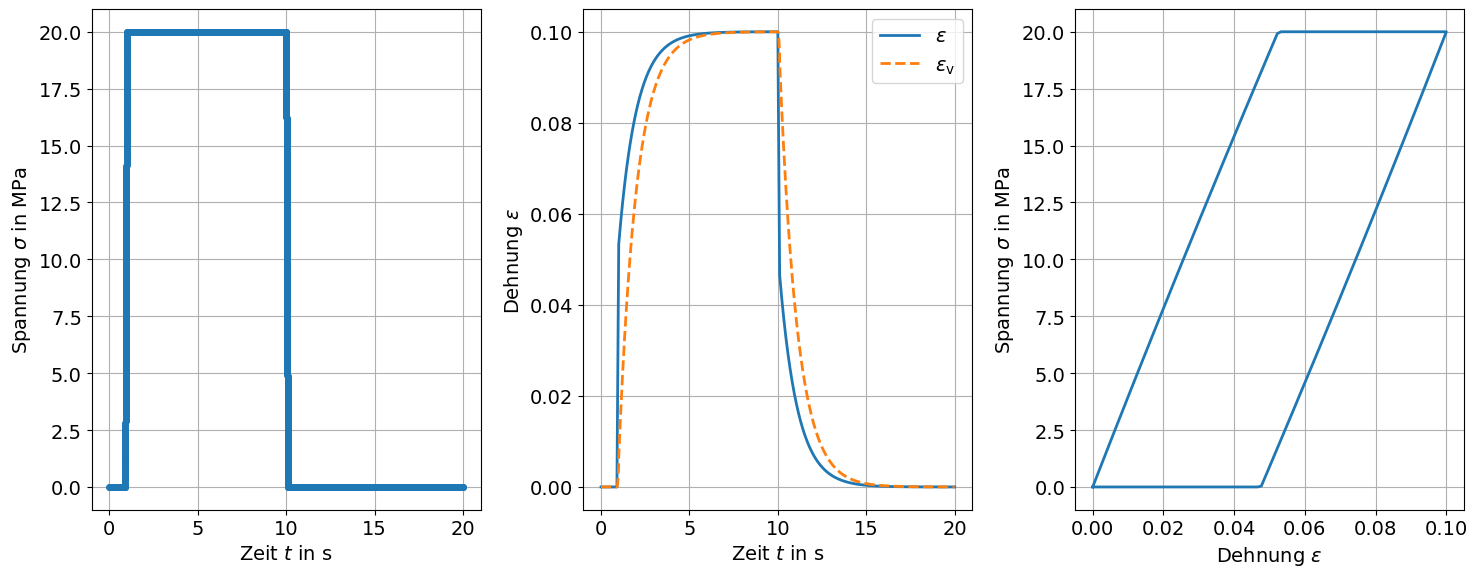

In [14]:
# Skalierungsfaktor für die Anzahl der Datenpunkte pro Belastungsabschnitt
fct = 50

# Definition der Belastungsabschnitte
t_1, dt_1, sig_1 = generate_load(0.0, 0.9,  0.0,  0.0,  1*fct,  False)
t_2, dt_2, sig_2 = generate_load(0.9, 1.0,  0.0,  20.0, 5*fct,  False)
t_3, dt_3, sig_3 = generate_load(1.0, 10.0, 20.0, 20.0, 10*fct, False)
t_4, dt_4, sig_4 = generate_load(10.0, 10.1, 20.0, 0.0, 10*fct, False)
t_5, dt_5, sig_5 = generate_load(10.1, 20.0, 0.0, 0.0,  10*fct, True)

# Zusammenfügen der Arrays für die gesamte Belastung
t = np.concatenate([t_1, t_2, t_3, t_4, t_5])
dt = np.concatenate([dt_1, dt_2, dt_3, dt_4, dt_5])
sig = np.concatenate([sig_1, sig_2, sig_3, sig_4, sig_5])

# Materialparameter des linearen Standardkörpers
E = 200.0 # MPa
eta = 100.0 # MPa s
Einf = 200.0 # MPa

# Initialisierung der Arrays für Dehnung und viskose Dehnung
eps = np.zeros_like(sig)
epsv = np.zeros_like(sig) # (zu Beginn ist epsv = 0)

# Berechnung der Dehnung und viskosen Dehnung für jeden Zeitschritt
for i in range(1,len(sig)):
    # Berechnung der aktuellen Dehnung und viskosen Dehnung
    # unter Verwendung der Werte aus dem vorherigen Zeitschritt (i-1)
    eps[i], epsv[i] = strain_res(sig[i], epsv[i-1], dt[i], Einf, E, eta)

# Plot 1: Zeitlicher Verlauf der Spannung
plt.subplot(131)
plt.plot(t, sig, '-', marker='o', markersize=4)
plt.xlabel(r'Zeit $t$ in $\mathrm{s}$')
plt.ylabel(r'Spannung $\sigma$ in $\mathrm{MPa}$')
plt.tight_layout()

# Plot 2: Zeitlicher Verlauf der Dehnung
plt.subplot(132)
plt.plot(t, eps, '-', label=r'$\varepsilon$')
plt.plot(t, epsv, '--', label=r'$\varepsilon_\mathrm{v}$')
plt.xlabel(r'Zeit $t$ in $\mathrm{s}$')
plt.ylabel(r'Dehnung $\varepsilon$')
plt.legend()
plt.tight_layout()

# Plot 3: Spannungs-Dehnungs-Diagramm
plt.subplot(133)
plt.plot(eps, sig, '-')
plt.xlabel(r'Dehnung $\varepsilon$')
plt.ylabel(r'Spannung $\sigma$ in $\mathrm{MPa}$')
plt.tight_layout()

---
# Beispiel: Relaxationsversuch mit Parameterstudie

Nachdem wir das Verhalten des linearen Standardkörpers erfolgreich mit unserem Programm simuliert haben, können wir nun den Einfluss verschiedener Materialparameter untersuchen. Es soll eine Parameterstudie für den Relaxationsversuch mit den Viskositätswerten $\eta = \{100, 25, 10\}$ MPa s durchgeführt werden.

---
**Aufgabe**

Vervollständigen Sie den folgenden Programmcode, um die Parameterstudie für den Relaxationsversuch durchzuführen.

**Hinweis**:
Orientieren Sie sich an der Implementierung des Relaxationsversuchs.

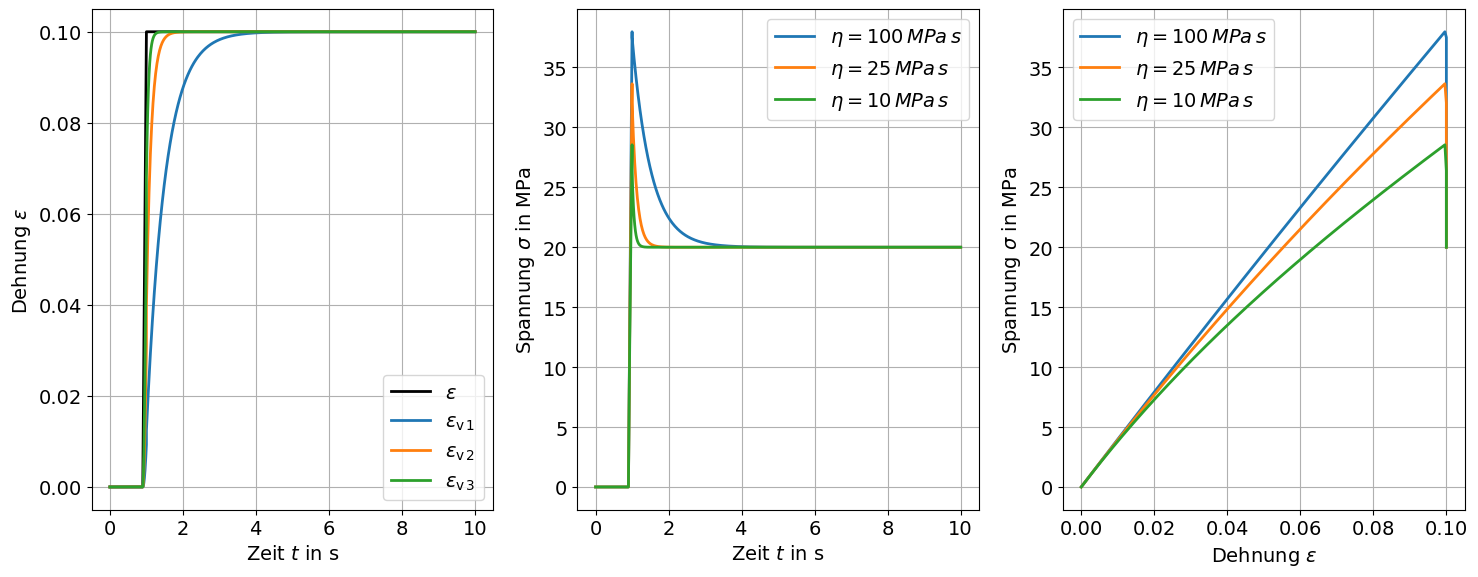

In [15]:
# Skalierungsfaktor für die Anzahl der Datenpunkte pro Belastungsabschnitt
fct = 50

# Definition der Belastungsabschnitte
t_1, dt_1, eps_1 = generate_load(0.0, 0.9,  0.0, 0.0, 1*fct,  False)
t_2, dt_2, eps_2 = generate_load(0.9, 1.0,  0.0, 0.1, 5*fct,  False)
t_3, dt_3, eps_3 = generate_load(1.0, 10.0, 0.1, 0.1, 10*fct, True)

# Zusammenfügen der Arrays für die gesamte Belastung
t = np.concatenate([t_1, t_2, t_3])
dt = np.concatenate([dt_1, dt_2, dt_3])
eps = np.concatenate([eps_1, eps_2, eps_3])

# Anzahl der Parametersätze und Definition der Materialparameter
nmatParams = 3
#             Einf (MPa) eta (MPa s) E (MPa)
matParams = [(200.0,     100.0,      200.0),  # Parametersatz 1
             (200.0,     25.0,       200.0),  # Parametersatz 2
             (200.0,     10.0,       200.0),  # Parametersatz 2
            ]

# Initialisierung der Arrays für Spannung und viskose Dehnung (für alle Parametersätze)
sig = np.zeros((nmatParams, len(eps)))
epsv = np.zeros((nmatParams, len(eps))) # (zu Beginn ist epsv = 0 für jeden Parametersatz)

# Berechnung für jeden Parametersatz
for iParam in range(nmatParams):
    # Materialparameter für diesen Satz
    Einf, eta, E = matParams[iParam]

    # Berechnung der Spannung und viskosen Dehnung für jeden Zeitschritt (für diesen Parametersatz)
    for i in range(len(eps)):
        sig[iParam, i], epsv[iParam, i] = stress(eps[i], epsv[iParam, i-1], dt[i], Einf, E, eta)    

# Diagramm 1: Zeitlicher Verlauf der Dehnung (alle Parametersätze)
plt.subplot(131)
plt.plot(t, eps, 'k-', label=r'$\varepsilon$')
plt.plot(t, epsv[0,:], '-', label=r'$\varepsilon_\mathrm{v\,1}$')
plt.plot(t, epsv[1,:], '-', label=r'$\varepsilon_\mathrm{v\,2}$')
plt.plot(t, epsv[2,:], '-', label=r'$\varepsilon_\mathrm{v\,3}$')
plt.xlabel(r'Zeit $t$ in $\mathrm{s}$')
plt.ylabel(r'Dehnung $\varepsilon$')
plt.legend()
plt.tight_layout()

# Plot 2: Zeitlicher Verlauf der Spannung (alle Parametersätze)
plt.subplot(132)
plt.plot(t, sig[0,:], '-', label=r'$\eta = 100 \, MPa \, s$')
plt.plot(t, sig[1,:], '-', label=r'$\eta = 25 \, MPa \, s$')
plt.plot(t, sig[2,:], '-', label=r'$\eta = 10 \, MPa \, s$')
plt.xlabel(r'Zeit $t$ in $\mathrm{s}$ ')
plt.ylabel(r'Spannung $\sigma$ in $\mathrm{MPa}$')
plt.legend()
plt.tight_layout()

# Plot 3: Spannungs-Dehnungs-Diagramm (alle Parametersätze)
plt.subplot(133)
plt.plot(eps, sig[0,:], '-', label=r'$\eta = 100 \, MPa \, s$')
plt.plot(eps, sig[1,:], '-', label=r'$\eta = 25 \, MPa \, s$')
plt.plot(eps, sig[2,:], '-', label=r'$\eta = 10 \, MPa \, s$')
plt.xlabel(r'Dehnung $\varepsilon$')
plt.ylabel(r'Spannung $\sigma$ in $\mathrm{MPa}$')
plt.legend()
plt.tight_layout()

---
# Weiterführende Aufgaben

Zur Vertiefung Ihres Verständnisses des linearen Standardkörper können Sie
- weitere Parameterstudien für den Relaxations- und Kriechversuch durchführen,
- komplexere Lastpfade inklusive Entlastung untersuchen und darüber
- die analytische Lösung aus der Übung 4.3 reproduzieren, sowie
- die Materialantworten der Kelvin-Voigt- und Maxwell-Körper berechnen.<br>(durch eine geeignete Wahl der Materialparameter)